In [1]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
#| code-fold: true

plt.style.use('arviz-doc')
RANDOM_SEED = 5781

Angteriormente analizamos los Procesos Gaussianos (GPs}, particularmente en el contexto de regresión. En este capítulo, aprenderemos sobre otro modelo no paramétrico de regresión conocido como árboles de regresión aditiva bayesiana o BART, para los amigos. La esencia es BART es usar una suma de árboles regularizada por un prior. Prácticamente en la totalidad de la literatura, BART se discute como un modelo independiente y el software que lo implementa generalmente se limita a uno o unos pocos modelos predeterminados. Nosotros vamos a discutirlo en el mismo contexto en el que hemos discutio el resto de los tópicos de este curso, en el contexto de la programación probabilista

En este capítulo, cubriremos los siguientes temas:

* Árboles de decisión
* Modelos BART
* Regresión flexible con BART
* Gráficos de dependencia parcial
* Gráficos de expectativas condicionales individuales
* Selección de variables

## Árboles de decisión

Supongamos que tenemos dos variables $X_1$ y $X_2$ y queremos usar esas variables para clasificar objetos en dos clases: ⬤ o ▲. Para lograr este objetivo podemos utilizar una estructura de árbol como se muestra en el panel izquierdo de la siguiente figura.


![](img/decision_tree.png)

Un árbol es un grafo en el que cualquier par de vértices (o nodos) están conectados por exactamente un camino (o lado. El árbol de la figura anterior es un árbol binario porque cada nodo puede tener como máximo dos nodos hijos. Los nodos sin hijos se conocen como nodos hoja o nodos terminales. En este ejemplo tenemos dos nodos internos o interiores (representados como rectángulos) y 3 nodos terminales (representados como rectángulos redondeados). Cada nodo interno tiene una regla de decisión asociada. Si seguimos esas reglas de decisión, eventualmente llegaremos a un nodo hoja que nos proporcionará la respuesta a nuestro problema de decisión. Por ejemplo, si una instancia de la variable $X_1$ es mayor que $c_1$ el árbol de decisión nos dice que le asignemos a esa instancia la clase ⬤. Si en cambio observamos un valor de $x_{1i}$ menor que $c_1$ y el valor de $x_{2i}$ menor que $c_2$ entonces debemos asignar la clase ▲. 

Algorítmicamente podemos conceptualizar un árbol como un conjunto de declaraciones if-else que seguimos para realizar una determinada tarea, como una clasificación. Otra perspectiva útil es la geométrica. Podemos entender un árbol binario como una forma de dividir el espacio muestral en bloques, como se muestra en el panel derecho de la figura anterior cada bloque está definido por líneas de división (asociadas a las reglas de clasificación de los nodos internos). Cada división del espacio muestral se alineará con uno de los ejes de covariables.

En la discusión de BART resulta conveniente definir un árbol de decisión $g$ como una 2-tupla con elementos:

* $\mathcal{T}$ el conjunto de lados y nodos (los cuadrados, los cuadrados redondeados y las líneas que los unen en la figura anterior) junto con las reglas de decisión asociadas con los nodos internos.
* $\mathcal{M} = \{\mu_1, \mu_2, \dots, \mu_b\}$ denota un conjunto de valores de parámetros asociados con cada uno de los nodos terminales de $\mathcal{T}$.


Entonces $G(X; \mathcal{T}, \mathcal{M})$ es la función que asigna $\mu_i \in M$ a $X$. Por ejemplo, en la figura anterior los valores de $\mu_{i}$ son (⬤, ⬤ y ▲). Y la función $G$ asigna ⬤, a casos con $X_1$ mayor que $c_1$, ⬤, a $X_1$ menor que $c_1$ y $X_2$ mayor que $c_2$ y ▲, a $X_1$ menor que $c_1$ y $X_2$ menor que $c_2$.

## Árboles de regresión

En los árboles de decisión $\mathcal{M}_j$ contiene clases o valores de etiquetas. Pero en principio podemos asociar otros elementos como números reales. En la siguiente figura se muestra un caso de regresión con una sola covariable. A la izquierda vemos un árbol binario similar al de la anterior, con la principal diferencia de que en lugar de devolver un valor de clase en cada nodo hoja, el árbol devuelve un valor real. 


![](img/decision_tree_reg.png)

En este caso hemos aproximado una serie de puntos, que parecen seguir una curva sinusoidal, con tres valores constantes, que geométricamente podemos interpretar como tres segmentos no-continuos. En ese caso el valor de cada nodo hoja se corresponde con la media de los puntos correspondientes a su partición. La elección de la media es abritaria, algunas alternativas serían la media, lo que podría ofrecer robustes a valores extremos. O incluso funciones más complejas como una regresión lineal, un spline, un proceso Gaussiano o una red neuronal.  Sin embargo, la media es probablemente la opción más común para los árboles de regresión.

## interpretabilidad y flexibilidad



Es importante señalar que, en general, un árbol de regresión no es una aproximación "suave" o "continua" sino una función escalonada por partes, aunque existen excepciones en la literatura. Esto no significa que los árboles de regresión sean necesariamente una mala elección para ajustar funciones continuas. En principio podemos aproximar cualquier función continua con una función escalonada y en la práctica esta aproximación podría ser bastante buena.

Una característica atractiva de los árboles de decisión/regresión es su interpretabilidad: literalmente se puede leer el árbol y seguir los pasos necesarios para resolver un determinado problema. Y, por lo tanto, se puede comprender de forma transparente qué está haciendo el método, por qué funciona y por qué algunas clases pueden no estar clasificadas adecuadamente o por qué algunos datos no están bien aproximados. Además, también es fácil explicar el resultado a una audiencia no técnica con términos simples.

Además los árboles ofrence un método muy flexible, ya que siempre se puede encontrar un árbol lo suficientemente complejo como para que cada nodo hoja tenga asociado una observación. La contracara de esta flexibilidad es el sobreajuste. La siguiente figura muestra un ejemplo de un árbol que ha sobreajustado los datos.   


![](img/decision_tree_overfitting.png)

Otro punto a notar es que es posible encontrar más de un árbol que ajuste igualmente bien un conjunto de datos. Esto quiere decir que áun cuando interpretables, podríamos encontrar interpretaciones alternativas. Algo esperable de un método flexible.


Una propiedad interesante de los árboles surge cuando pensamos en ellos en términos de efectos e interacciones principales como lo hicimos con los modelos lineales. Observe que el término $\mathbb{E}(Y \mid \boldsymbol{X})$ es igual a la suma de todos los parámetros del nodo hoja $\mu_{ij}$, por lo tanto:

* Cuando un árbol depende de una sola variable cada uno de esos $\mu_{ij}$ representa un efecto principal
* Cuando un árbol depende de más de una variable, cada $\mu_{ij}$ representa un efecto de interacción. 

Por ejemplo en la primer figura del árbol de decisión, obntener un triángulo requiere la interacción de $X_1$ y $X_2$ ya que la condición del nodo secundario ($X_2 > c_2$) depende de la condición del nodo principal ($X_1 > c_1$).


Como en principio el tamaño de los árboles es variable, podemos utilizar árboles para modelar efectos de interacción de distintos órdenes. A medida que un árbol se vuelve más profundo, aumenta la posibilidad de utilizar más variables y por lo tanto de representar interacciones de orden superior.

## Conjuntos de árboles

Teniendo en cuenta que los árboles demasiado complejos probablemente no serán muy buenos para predecir datos nuevos, es común introducir dispositivos para regularizar la complejidad de los árboles y disminuir el riesgo de sobreajuste. Varias de las soluciones encontradas a lo largo de los años consisten en utilizar no un solo árbol, si no un conjunto de árboles donde la capacidad de aprendizaje/ajuste de cada árbol se limita. Es importante notar que una suma de árboles es otro árbol. Por lo que en principio serái posible trabajar con un solo árbol y encontrar una solución que no sobreajuste. Pero en la práctica se ha observado repetidas veces, que es mejor usar un conjunto. Esto es válido tanto para métodos no-bayesianos como random forest o bayesianos como BART.

Una desventaja de utilizar conjuntos de árboles es que perdemos la interpretabilidad de un único árbol. Para obtener una respuesta no podemos seguir un solo árbol, debemos considerar a todos, lo que generalmente dificulta cualquier interpretación directa. Hemos cambiado la interpretabilidad por la flexibilidad y la generalización.

## BART

De forma general podemos escribir un modelo BART como:

$$
Y = \phi \left(\sum_{j=0}^m G(\boldsymbol{X}; \mathcal{T}_i, \mathcal{M}_i), \theta \right)
\label{eq:bart}
$$


Donde $G$ representa una función árbol parametrizada por $\mathcal{T}_i$ y $\mathcal{M}_i$, que como ya vimos$\mathcal{T}_i$ representa la estructura de un árbol binario, es decir, el conjunto de nodos internos y sus reglas de decisión asociadas y un conjunto de nodos terminales. Mientras que $\mathcal{M}_i$ representa los valores en los nodos terminales. $\phi$ representa una distribución de probabilidad arbitraria que se usará como likelihood en nuestro modelo y $\theta$ otros parámetros de $\phi$ no modelados como una suma de árboles.

Por ejemplo si $\phi$ es una distribución Normal, podríamos usar la suma de árboles para representar la media $\mu$ y tendríamos a $\sigma$ como variable auxiliar.

$$
Y = \mathcal{N}\left(\mu = \sum_{j=0}^m G(\boldsymbol{X}; \mathcal{T}_j, \mathcal{M}_j), \sigma^2  \right)
$$

Como es habitual, para especificar completamente un modelo BART, debemos elegir los priors sobre $\mathcal{T}$ y $\mathcal{M}$. 

## Priors para BART

En el [artículo original](https://arxiv.org/abs/0806.3286) de BART y en la mayoría de las modificaciones e implementaciones posteriores, los priors para BART son conjugados. La implementación de BART en PyMC-BART no utiliza priors conjugados y también se desvía de otras maneras de gran parte del resto de la literatura. En lugar de discutir las diferencias nos centraremos en la implementación de PyMC-BART, que es la que vamos a utilizar para los ejemplos.

### Prios independientes

Para simplificar la especificación de los priors asumimos que la estructura del árbol $\mathcal{T}$ y los valores de las hojas $\mathcal{M}$ son independientes. Además estos priors son independientes de los priors para $\theta$. 

El prior para la estructura de árbol $\mathcal{T}$ se especifica mediante tres aspectos:

* La probabilidad de que un nodo de profundidad $d=(0, 1, 2, \dots)$ sea no terminal está dado por  $\alpha(1 + d)^{-\beta}$ con $\alpha \in (0, 1)$ y $\beta \in [0, \infty)$.

* La distribución sobre la variable de partición. Lo más habitual es que sea Uniforme entre las covariables disponibles. Es posible utilizar otras distribuciones. PyMC-BART permite pasar un vector `split_prior` que tiene la misma interpretación que el parámetro de concentración $\alpha$ en una distribución de Dirichlet.
* La distribución sobre los valores de partición. Es decir, una vez que elegimos una variable de partición, qué valor usamos para tomar una decisión. Es uniforme sobre los valores disponibles.


El prior para los valores de las hojas $\mu_{ij}


Usamos $\mathcal{N}(\mu_\text{pred}, {\varepsilon^2})$, donde $\mu_\text{pred}$ se calcula como la media de la suma actual de árboles dividida por número de árboles \texttt{m}. $\varepsilon$ se calcula inicialmente a partir de $Y$, siendo $\varepsilon = \frac{3}{\sqrt{m}}$ para datos binomiales y $\varepsilon = \frac{Y_\text{std}}{\sqrt{m}}$ para datos distintos del binomial. 


El número de árboles $m$ debe ser especificado por el usuario, valores comunmente usados suelen ser 50, 100 o 200. En general mientrás más árboles se utilizen mejor serán los resultados. Cuando se evalua usando LOO, en  general lo que se observa al aumentar $m$ es una saturación sin llegar a sobrejustar. Es decir LOO aumenta a medida que $m$ aumenta, pero el incremento va disminuyendo. Esto se puede explicar, al menos en parte, por el hecho que el aumento de $m$ implica un valor cada vez más pequeño de $\mu$. 



La especificación de los priors para BART, se desvía un poco de la especificación típica de priors en modelos Bayesianos, y la razón es que están diseñados para ser automáticos, algo similar a lo que hace Bambi. Por ejemplo usamos $Y$ para especificar $\mu$, además este valor de $\mu$ es solo utilizado inicialmente. Durante la fase de ajuste el valor de $\mu$ es actualizado utilizando la varianza de las predicciones de cada árbol ajustado. Algo similar sucede con las variables de partición, por defecto todas tienen la misma probabilidad, pero durante la fase de ajuste se va actualizando esta probabiliad de acuerdo a la frecuencia con la que las variables entran en los árboles. Esto disminuye la probabilidad de que variables espurias participen de la suma de árboles, mejorado el uso de los recursos computacionales y mejorando la estimación de la importancia de las variables. Es claro que estos "trucos" hacen que el método no sea 100% bayesiano, si no una aproximación.

## Inferencia sobre árboles de regresión aditiva bayesiana

Hasta ahora hemos discutido ideas generales sobre los árboles y algo sobre como especificar distribuciones a priori para árboles, pero no hemos discutido detalles de calcular una distribucion a posteriori de árboles. Hay muchas estrategias para hacer esto y los detalles son demasiado específicos para este curso. Por ese motivo vamos a describir sólo los elementos principales. Para más detalles pueden leer este [artículo](https://arxiv.org/abs/2206.03619).

Para ajustar los modelos BART no podemos usar métodos basados en gradientes como el Monte Carlo Hamiltoniana porque el espacio de los árboles es discreto, y por lo tanto no hay forma directa de obtener gradientes. Por esa razón, se han desarrollado métodos de muestreo específicos para árboles, muchos de ellos son variantes de MCMC.

A grandes raszgos, cada paso del método implementado en PyMC-BART consiste en elegir uno de los $m_i$ árboles disponibles y proponer un nuevo árbol que lo reemplaze. Para ello se procede de la siguiente forma

1) Se hacen crecer $N$ árboles, comenzando desde la raíz y siguiendo los priors.
2) Se calcula un peso para cada uno de los $N$ árboles y para el árbol $m_i$
3) Se muestrea un árbol de forma proporcional a los pesos del punto anterior

En este algoritmo los priors son utilizado como distribución de propuesta, esto no es lo más común. En métodos como MH, HMC, NUTS, etc la distribución de propuesta y los priors son objetos distintos. El peso calculado en el punto 2 es el log-likelihood, teniendo en cuenta la suma del árbol de propuesta y todos los demás árboles $m_{-i}$. La razón de incluir a $m_i$, es garantizar que la probabilidad de no-innovar sea no nula. Además, como sucede con métodos MCMC, la probabilidad de elegir un árbol que "empeore" el ajuste es no nula.

Este procedimiento se repite hasta ajustar los $m$ árboles. Es importante notar que la suma de los $m$ árboles representa un punto en el espacio de la distribución a posteriori. Es decir, para obtener 1000 muestras de la distribución a posteriori necesitamos calcular $1000 \times m$ árboles. En la práctica PyMC-BART solo ajusta un subconjunto de los $m$ árboles por iteración, lo que permite reducir el costo computacional.

Los parámetros $\theta$, es decir los parametros que no están vinculados a la suma de áboles, se calculan con los métodos estándar de PyMC. Es decir que la distribución a posteriori se consigue con una combinación de métodos de muestreo.

## Minería de carbón con BART

Para comprender mejor BART en la práctica, utilizaremos dataset de la minería del carbón que ya usamos en dos ejemplos anteriores. En lugar de pensar este problema como un modelo de punto de cambio con dos distribuciones de Poisson, como en el ejemplo original de PyMC. Vamos a pensar en este problema como una regresión no paramétrica con una respuesta de Poisson (esto generalmente se discute en términos de [procesos de Poisson](https://en.wikipedia.org/wiki/Poisson_point_process) o [procesos de Cox]( https://en.wikipedia.org/wiki/Cox_process).

Debido a que nuestros datos son solo una columna con fechas, necesitamos realizar un procesamiento previo. Vamos a discretizar los datos, como si estuviéramos construyendo un histograma. Vamos a utilizar los centros de los *bins* como la variable $X$ y la frecuencia por *bin* como la variable $Y$.

In [3]:
coal = np.loadtxt("datos/coal.csv")

In [4]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist

Una variable BART se puede definir de manera muy similar a otras variables aleatorias. Una diferencia importante es que tenemos que pasar los valores de X e Y a la variable BART, esta información se usa al muestrear árboles. 

Aquí también dejamos explícito que vamos a utilizar una suma de 20 árboles (`m=20`). Un número bajo de árboles como 20 podría ser suficiente para modelos simples como este y también podría funcionar muy bien como una aproximación rápida para modelos más complejos, en particular durante la etapa inicial del modelado, cuando es posible que queramos probar algunas cosas tan rápido como sea posible.

In [5]:
with pm.Model() as modelo_coal:
    μ_ = pmb.BART("μ_", X=x_data, Y=np.log(y_data), m=20)
    μ = pm.Deterministic("μ", pm.math.exp(μ_))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Antes de comprobar el resultado, necesitamos discutir un detalle más, la variable BART siempre devuelve muestras en los reales, lo que significa que en principio podemos obtener valores que van desde $-\infty$ hasta $\infty$. Por lo tanto, es posible que necesitemos transformar estos valores como lo haríamos para modelos lineales generalizados, por ejemplo en `modelo_coal` calculamos `pm.math.exp(μ_)` porque la distribución de Poisson espera valores que van de 0 a $\infty$. Hasta acá no hay demasiada novedad. Lo nuevo es que es posible que necesitemos aplicar la transformación inversa a los valores de $Y$, como hicimos en el modelo anterior donde tomamos $\log(Y)$. Como ya mencionamos los valores del argumento `Y` se utilizan para obtener un valor inicial razonable. Por tanto, aplicar la transformación inversa es una forma sencilla de mejorar la eficiencia y precisión del resultado. ¿Deberíamos hacer esto siempre? Bueno no. Si usamos BART para el parámetro $\mu$ de distribuciones como Normal, T de Student o LaplaceAsimétrica, no necesitamos hacer nada ya que el soporte de estos parámetros son los reales. Ahora, una excepción no trivial es cuando usemos como likelihod Bernoulli (o Binomial con n=1), en ese caso, necesitamos aplicar la función logística a la variable BART, pero no es necesario aplicar su inversa para transformar `Y`, PyMC-BART es capaz de lidiar con este caso particular internamente.

Bien, ahora veamos el resultado de `modelo_coal`.

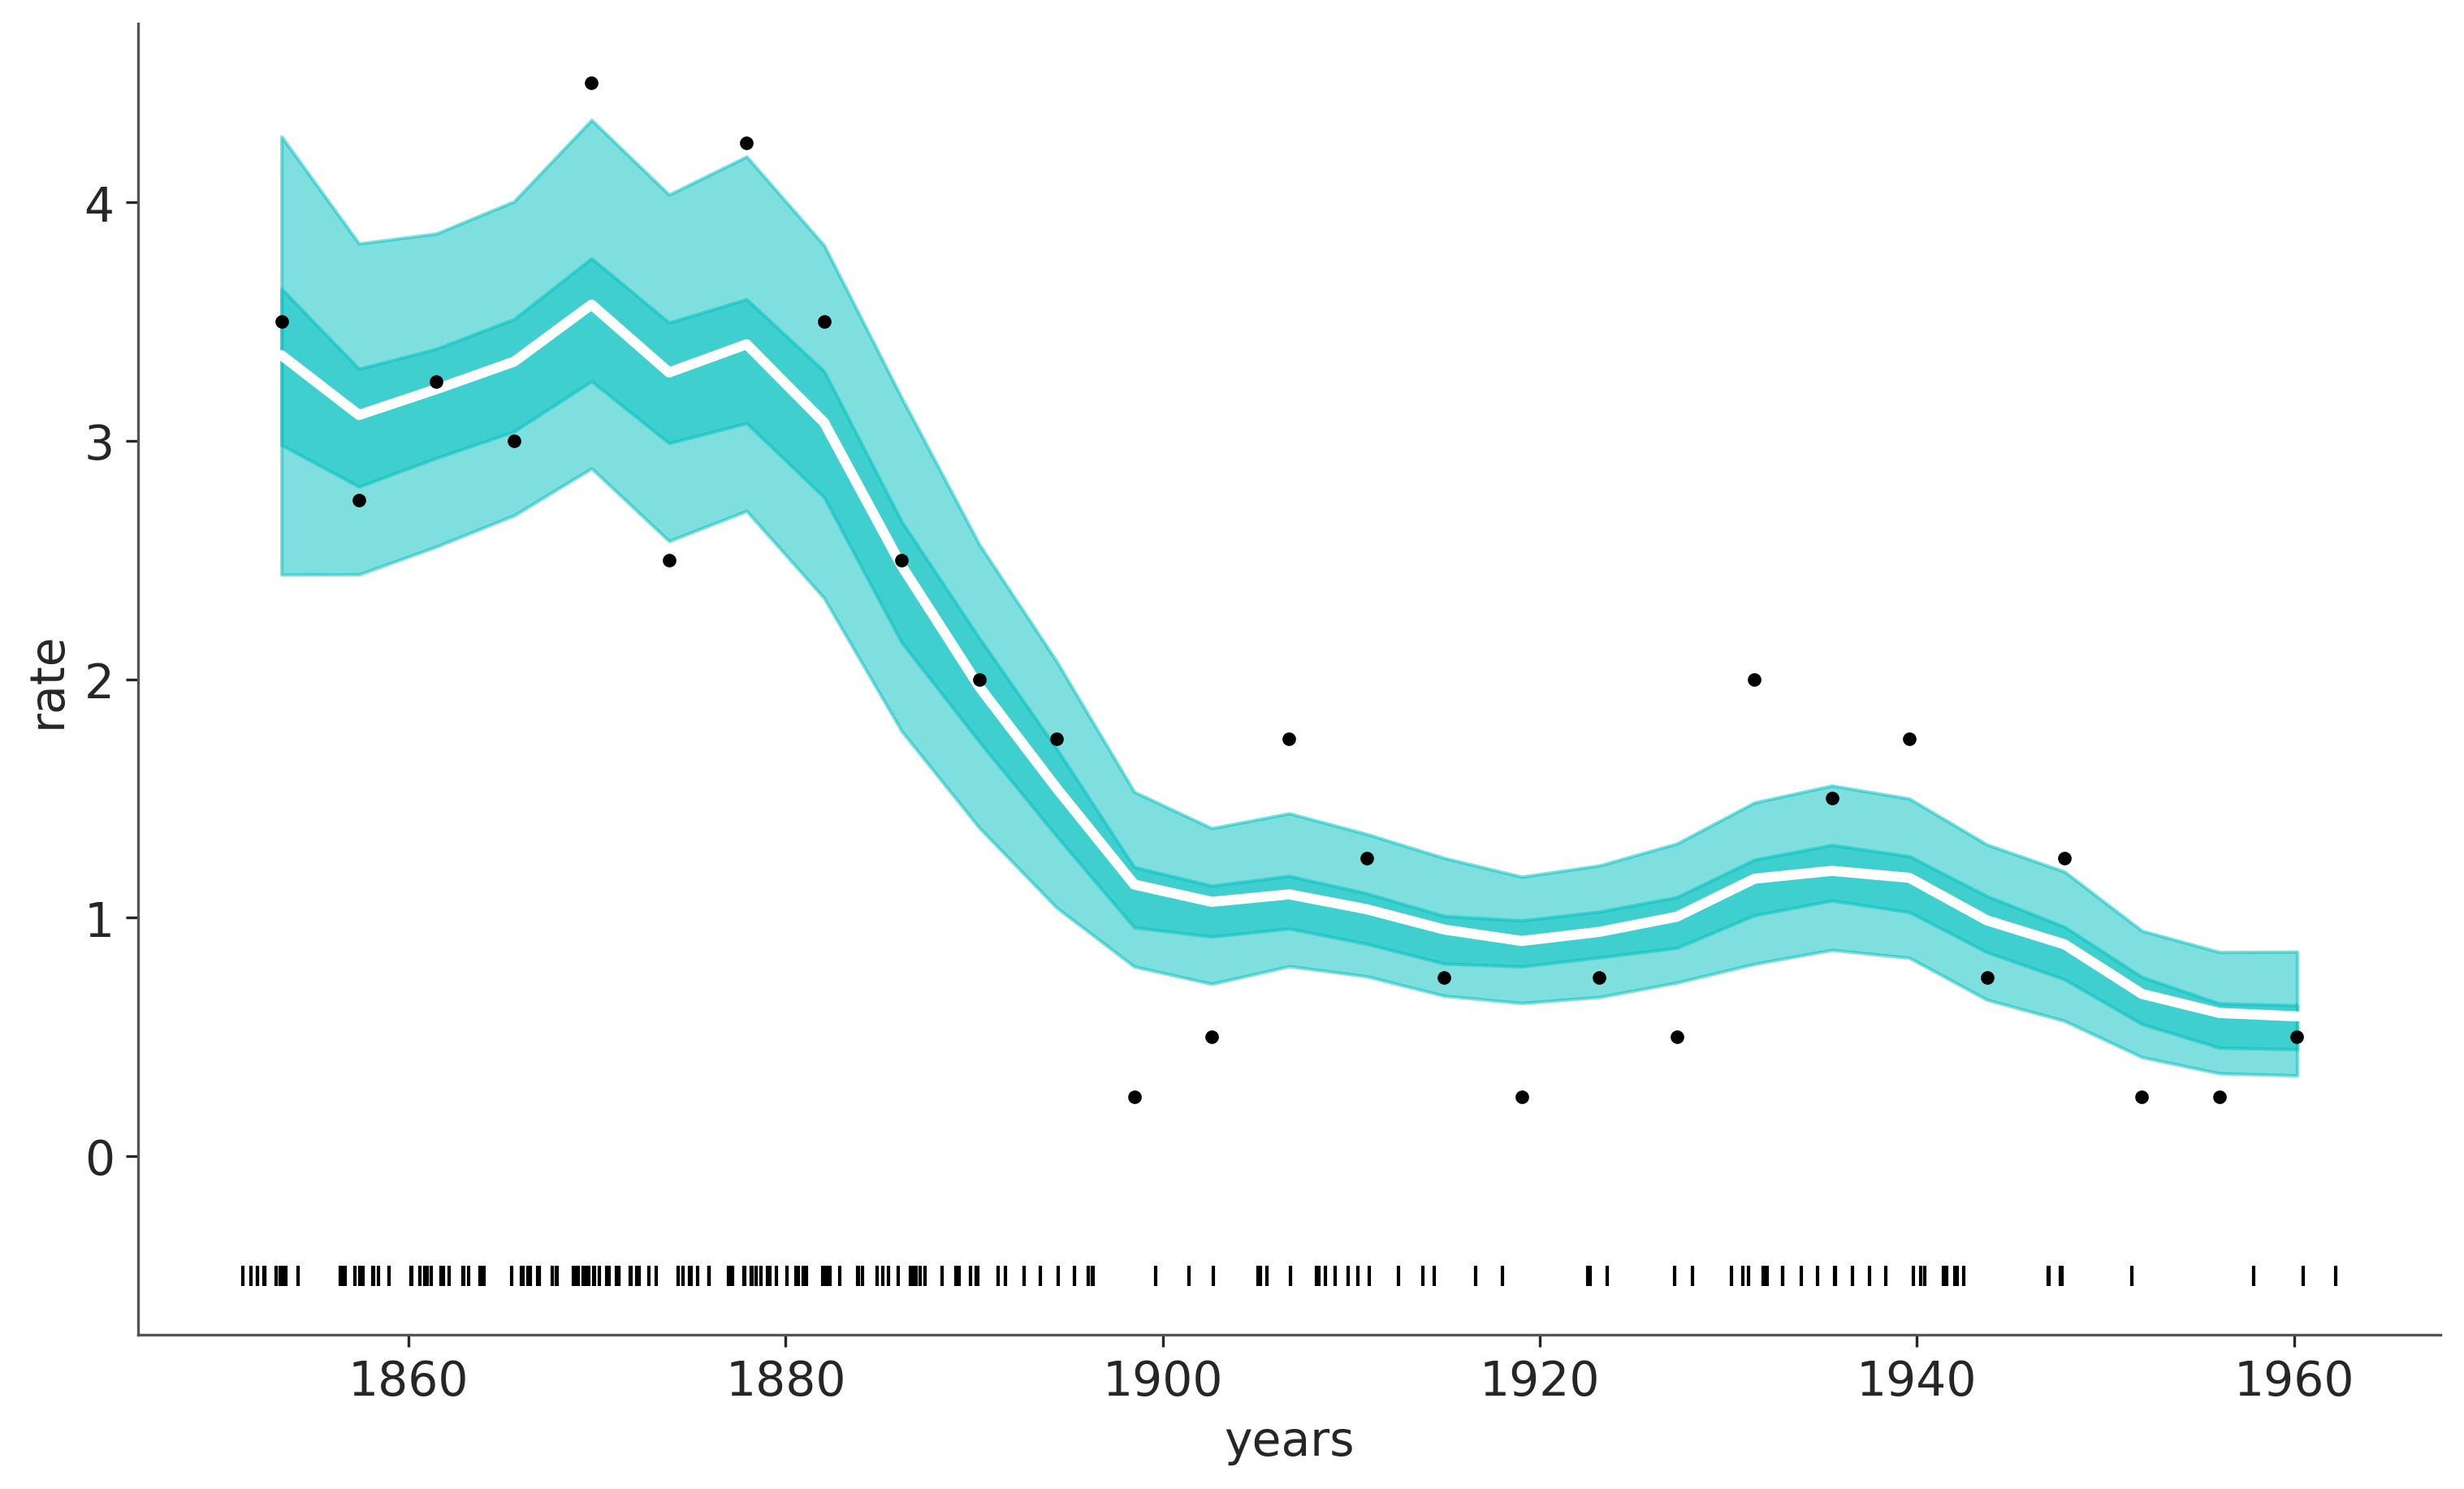

In [6]:
#| code-fold: true
_, ax = plt.subplots(figsize=(10, 6))

rates = idata_coal.posterior["μ"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

La línea blanca en el gráfico anterior muestra la tasa media de accidentes. La franja cyan más oscura representa el HDI 50% y la más clara el HDI 94%. Podemos ver una rápida disminución en los accidentes relacionados con el carbón entre 1880 y 1900. 

En el gráfico anterior, la línea blanca es la media de 4000 muestras de la distribución a posteriori, y cada uno de esos muestras es una suma de 20 árboles.

## Bicicleteando con BART

Veamos otro ejemplo, esta vez usando el dataset de bikes.

In [7]:
bikes = pd.read_csv("datos/bikes.csv")

features = ["hour", "temperature", "humidity", "weekday"]

X = bikes[features]
Y = bikes["rented"]

In [8]:
with pm.Model() as model_bikes:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    idata_bikes = pm.sample(compute_convergence_checks=False, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.


### Diagnóstico de convergencia

Para verificar la convergencia de muestreo de los modelos BART, recomendamos un enfoque de 2 pasos.

* Para las variables que no son BART (como $\alpha$ en `model_bikes`) seguimos las recomendaciones estándar, como verificar los diagnósticos numéricos R-hat (<= 1.01) y ESS (< 100x número de cadenas), así como usar trazar gráficos o incluso mejores gráficos de clasificación
* Para las variables BART recomendamos utilizar la función `pmb.plot_convergence`.

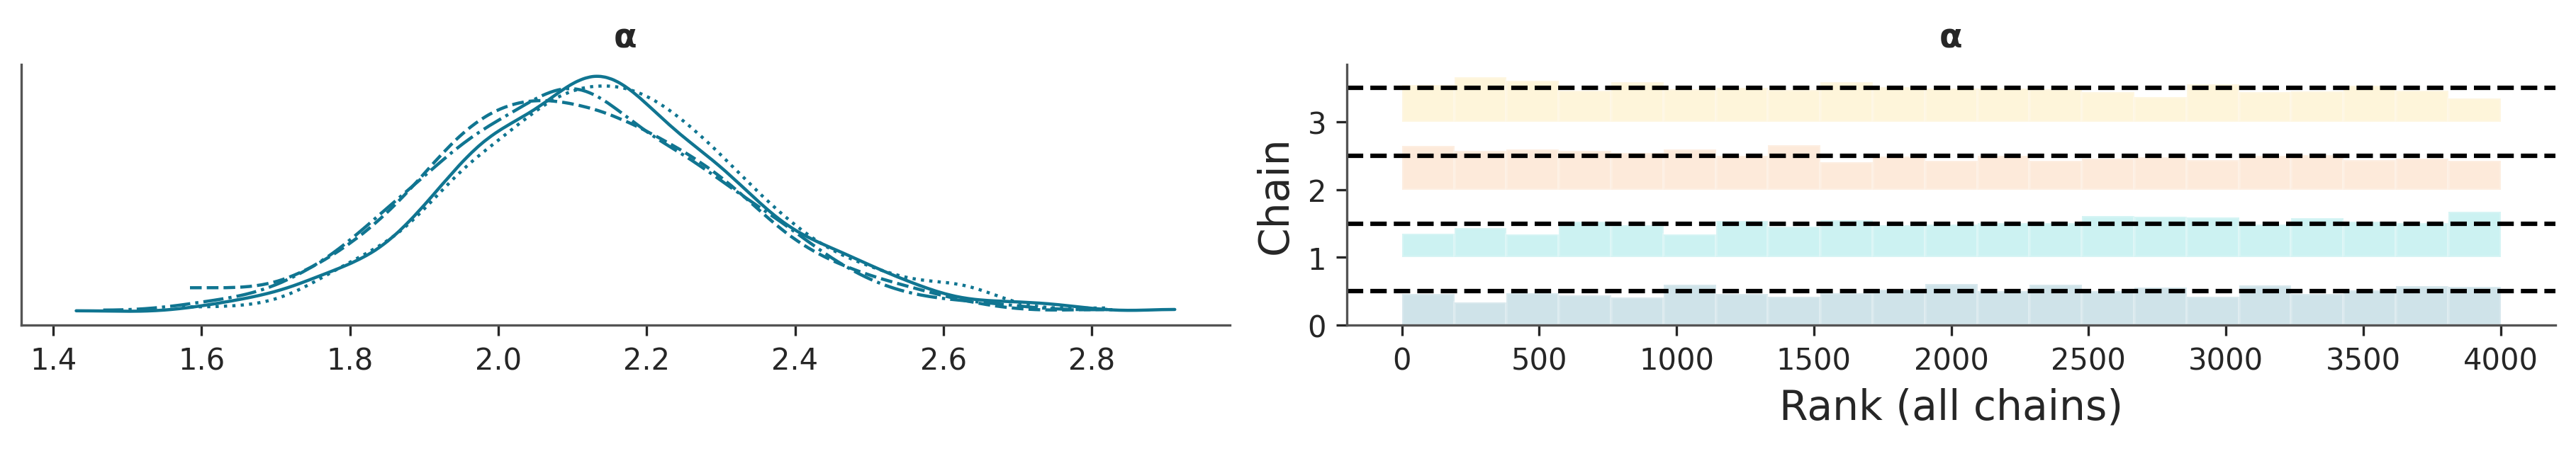

In [9]:
az.plot_trace(idata_bikes, var_names=["α"], kind="rank_bars");

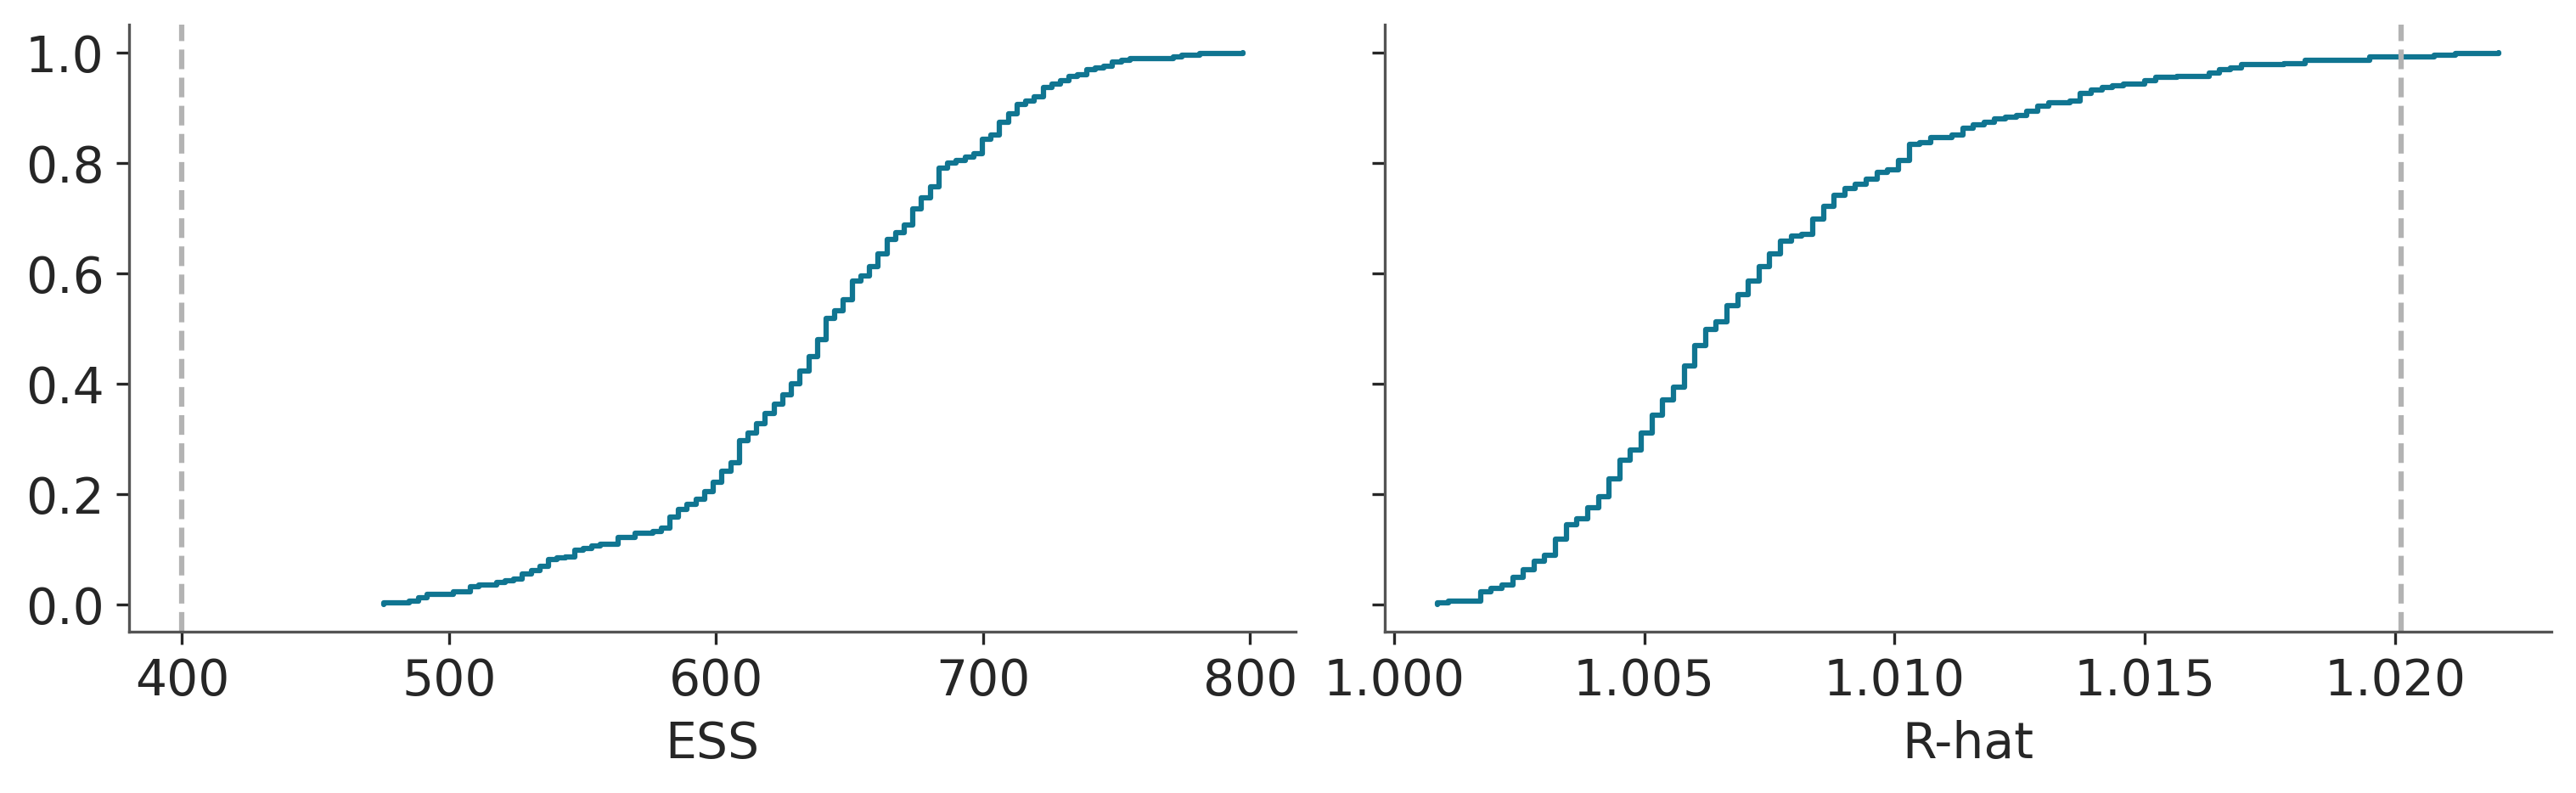

In [10]:
pmb.plot_convergence(idata_bikes, var_name="μ");

En la literatura de BART, el diagnóstico de las variables de BART a veces se considera menos importante que el diagnóstico de las variables que no son de BART; el argumento principal es que las estimaciones individuales de las variables latentes no tienen ningún interés directo y, en cambio, solo deberíamos preocuparnos. sobre qué tan bien estamos estimando toda la función/regresión.

En cambio, consideramos que verificar la convergencia de las variables BART es una parte importante del flujo de trabajo bayesiano. La razón principal para usar `pmb.plot_convergence` es que normalmente la variable BART será un vector grande (estimamos una distribución por observación) y, por lo tanto, necesitaremos verificar una gran cantidad de diagnósticos. Además, el umbral de R-hat de 1,01 no es un umbral estricto; este valor se eligió suponiendo que se examinan uno o varios R-hat (y que las cadenas son lo suficientemente largas para estimar con precisión su autocorrelación), y si observamos una gran cantidad de R-que se espera que algunos de ellos sean mayores que el umbral de 1,01 (o cualquier umbral que elijamos) incluso si no hay nada malo en nuestra inferencia. Por esa razón, un análisis justo debe incluir un ajuste de comparación múltiple, y eso es lo que `pmb.plot_convergence` hace automáticamente por usted. Entonces, ¿cómo leer su salida? Tenemos dos paneles uno para ESS y otro para R-hat. La línea azul es la distribución acumulativa empírica de esos valores, para ESS queremos que toda la curva esté por encima de la línea discontinua y para R-hat queremos que la curva esté completamente por debajo de la línea discontinua. En la figura anterior, podemos ver que apenas lo logramos para ESS y para R-hat tenemos muy pocos valores por encima del umbral. ¿Son nuestros resultados inútiles? Probablemente no. Pero, sin duda, es posible que queramos realizar algunos sorteos más.

## Partial dependence plots

Para ayudarnos a interpretar los resultados de nuestro modelo, utilizaremos gráficos de dependencia parcial. Este es un tipo de gráfico que muestra el efecto marginal que tiene una covariable sobre la variable predicha. Es decir, ¿cuál es el efecto que tiene una covariable $X_i$ sobre $Y$ mientras promediamos todas las demás covariables ($X_j, \forall j \not = i$). Esta herramienta no es exclusiva de BART. Pero se utilizan a menudo en la literatura de BART. PyMC-BART proporciona una función de auxiliar para realizar este gráfico a partir de una variable aleatoria BART.

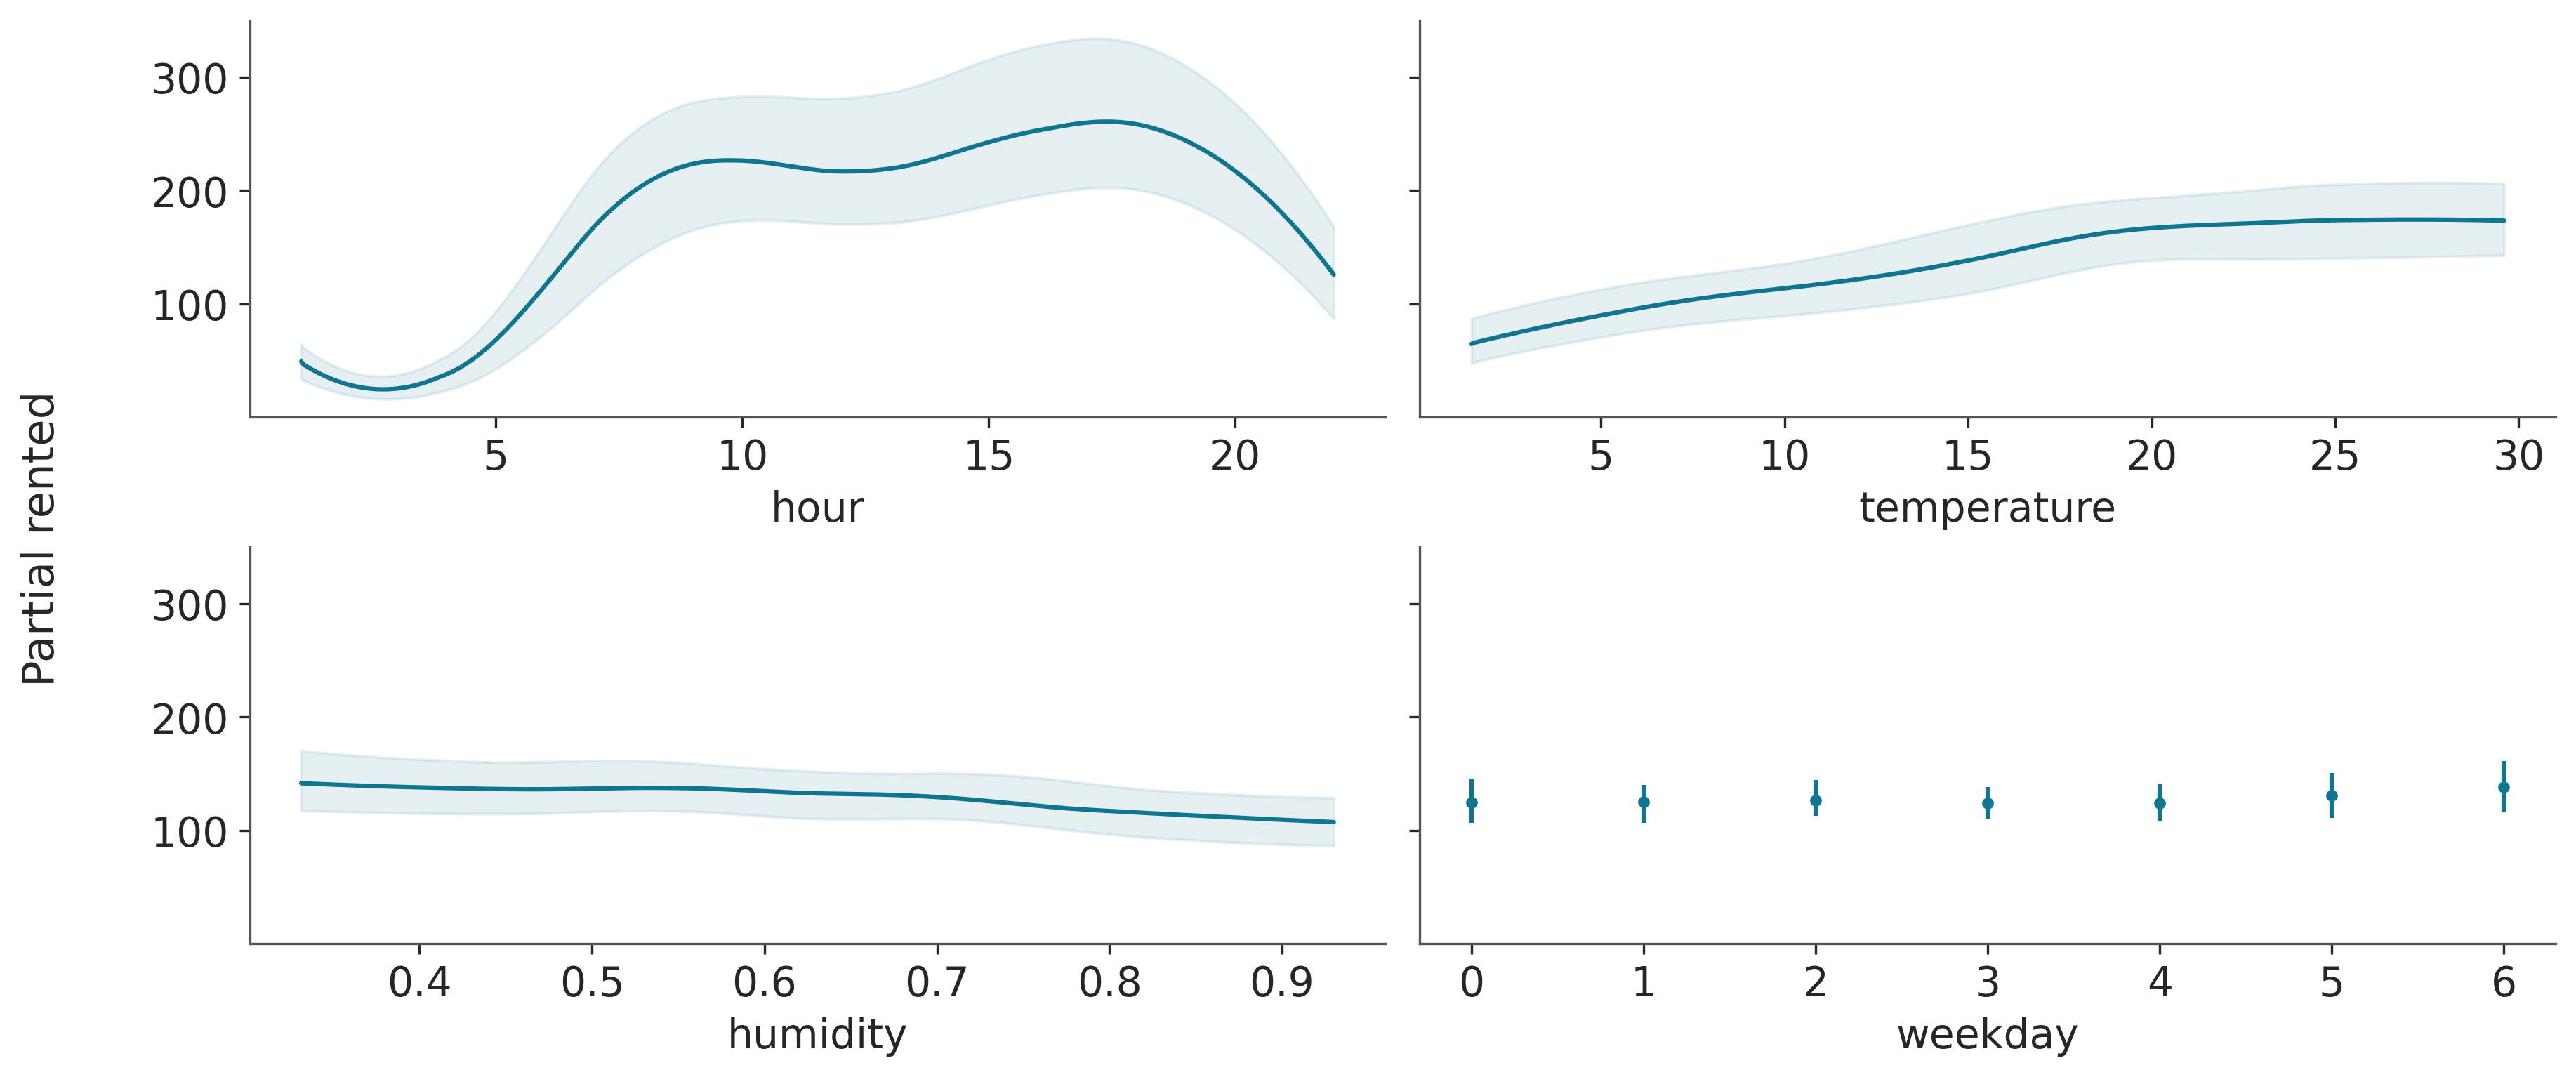

In [11]:
pmb.plot_pdp(μ, X=X, Y=Y, grid=(2, 2), func=np.exp, var_discrete=[3]);

En este gráfico, podemos ver el efecto principal de cada covariable sobre el valor predicho. Esto es muy útil ya que podemos recuperar relaciones complejas más allá de efectos monótonos crecientes o decrecientes. Por ejemplo para la covariable "hora" podemos ver dos picos alrededor de las 8 y 17 hs y un mínimo a medianoche.

Al interpretar gráficos de dependencia parcial debemos tener cuidado con los supuestos de este gráfico. Primero, asumimos que las variables son independientes. Por ejemplo, al calcular el efecto de la "hora" tenemos que marginar el efecto de la "temperatura" y esto significa que para calcular el valor de dependencia parcial en "hora=0" estamos incluyendo todos los valores de temperatura observados, y esto puede incluir temperaturas. que no se observan a medianoche, dado que es más probable que haya temperaturas más bajas que más altas. Solo estamos viendo promedios, por lo que si para una covariable la mitad de los valores están asociados positivamente con la variable predicha y la otra mitad está asociada negativamente. La gráfica de dependencia parcial será plana ya que sus contribuciones se cancelarán entre sí. Este es un problema que se puede resolver utilizando gráficos de expectativas condicionales individuales `pmb.plot_ice(...)`. Observe que todos estos supuestos son supuestos del gráfico de dependencia parcial, ¡no de nuestro modelo! De hecho, BART puede acomodar fácilmente interacciones de variables (aunque el prior en BART regulariza interacciones de alto orden). Para obtener más información sobre la interpretación de los modelos de aprendizaje automático, puede consultar el libro "Aprendizaje automático interpretable" {cite:p}`molnar2019`.

Finalmente, al igual que con otros métodos de regresión, debemos tener cuidado de que los efectos que observamos en las variables individuales estén condicionados a la inclusión de otras variables. Así, por ejemplo, aunque la "humedad" parece ser mayoritariamente plana, lo que significa que esta covariable tiene un pequeño efecto en el número de bicicletas usadas. Este podría ser el caso porque la "humedad" y la "temperatura" están correlacionadas hasta cierto punto y una vez que incluimos la "temperatura" en nuestro modelo, la "humedad" no proporciona demasiada información adicional. Intente, por ejemplo, ajustar el modelo nuevamente, pero esta vez con "humedad" como covariable única y luego ajustar el modelo nuevamente con "hora" como covariable única. Debería ver que el resultado de este modelo de variable única será muy similar a la figura anterior para la covariable "hora", pero menos similar para la covariable "humedad".

### Selección de variable

Como vimos en la sección anterior, un gráfico de dependencia parcial nos permite interpretar el efecto (marginal) de cada covariable sobre la respuesta. Además nos da una idea de cuánto contribuye cada covariable a la variable predicha. Pero hay una forma más directa de hacer esto. Veamos primero un gráfico y luego como intepretarlo y calcularlo.

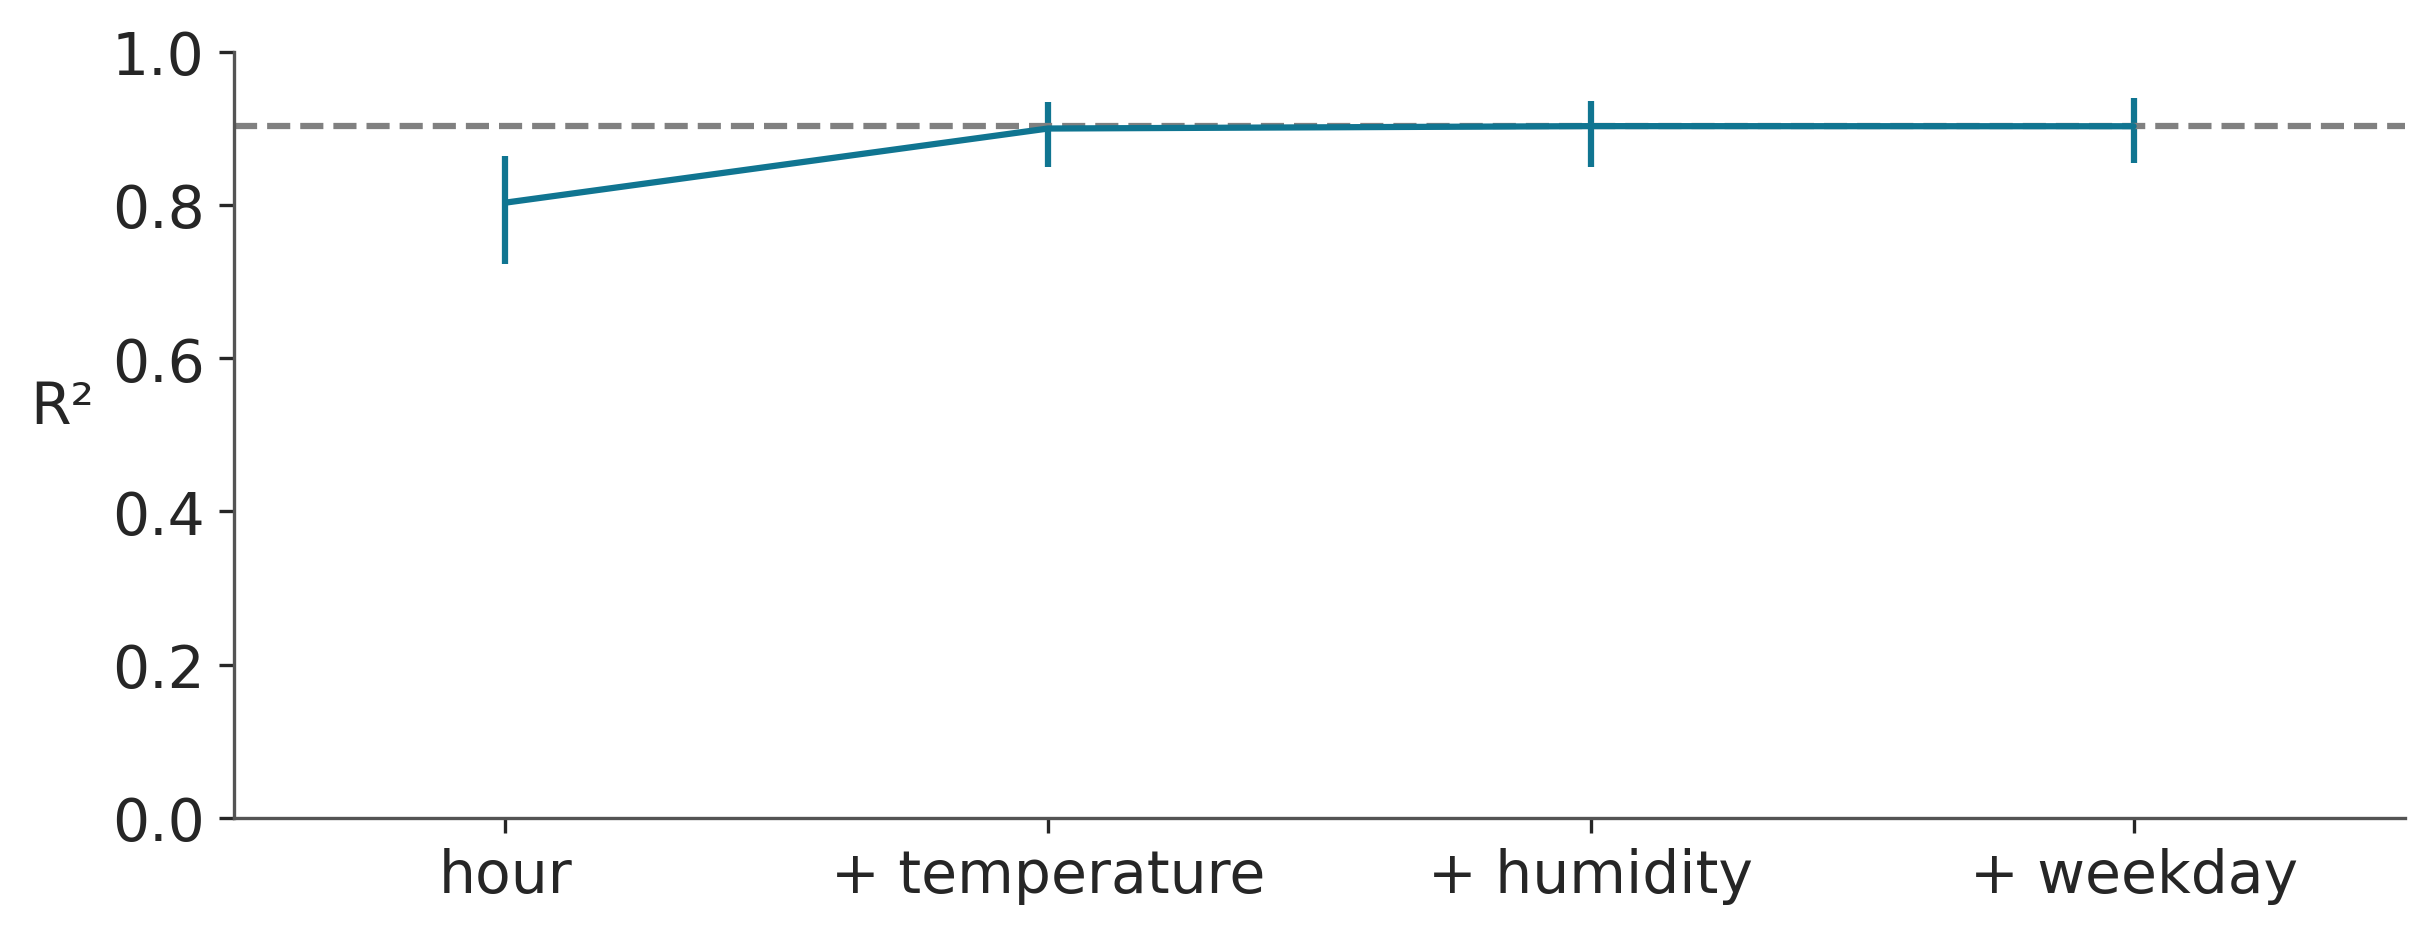

In [12]:
pmb.plot_variable_importance(idata_bikes, μ, X);

En el eje x tenemos los nombres de las covariables y en el eje y el R² (el cuadrado del coeficiente de correlación de Pearson) entre las predicciones realizadas para el modelo completo (todas las variables incluidas) y los submodelos, aquellos con sólo un subconjunto de las variables.

En este ejemplo, la variable más importante es "hora", luego "temperatura", "humedad" y finalmente "día de la semana". Observe que el primer valor de R² es el valor de un modelo que solo incluye la variable "hora", el segundo R² es para un modelo con dos variables, "hora" y "temperatura", y así sucesivamente. Podemos ver como un modelo con las variables "hora" y "temperatura", es capaz de hacer predicciones equivalentes a un modelo con todas las variables. Las barras de error representan el 94% HDI de la distribución predictiva a posteriori.


`plot_variable_importance` es rápido porque hace dos suposiciones:

* El ordenamiento de las variables se calcula con una heurística simple. Contamos cuántas veces se incluye una variable en todos los árboles de regresión. La intuición es que si una variable es importante debería aparecer con más frecuencia en los árboles ajustados que las variables menos importantes.

* Las predicciones utilizadas para el cálculo de R² provienen de los árboles ya ajustados. Por ejemplo, para estimar el efecto de un modelo BART con la variable `hora` *podamos* la rama que no incluye esta variable. Esto hace que los cálculos sean mucho más rápidos, ya que no necesitamos encontrar un nuevo conjunto de árboles. Esto es similar a lo que hacemos al calcular un partial depence plot

En lugar de utilizar la "heurística de conteo". También puede realizar una búsqueda hacia atrás, `pmb.plot_variable_importance(..., method="backward")`. Internamente, esto calculará el R² para el modelo completo, luego para todos los modelos con una variable menos que el modelo completo, y luego para todos los modelos con menos de dos, y así sucesivamente. En cada etapa, descartamos la variable que da el R² más bajo. El método inverso será más lento, ya que necesitamos calcular predicciones para más modelos.

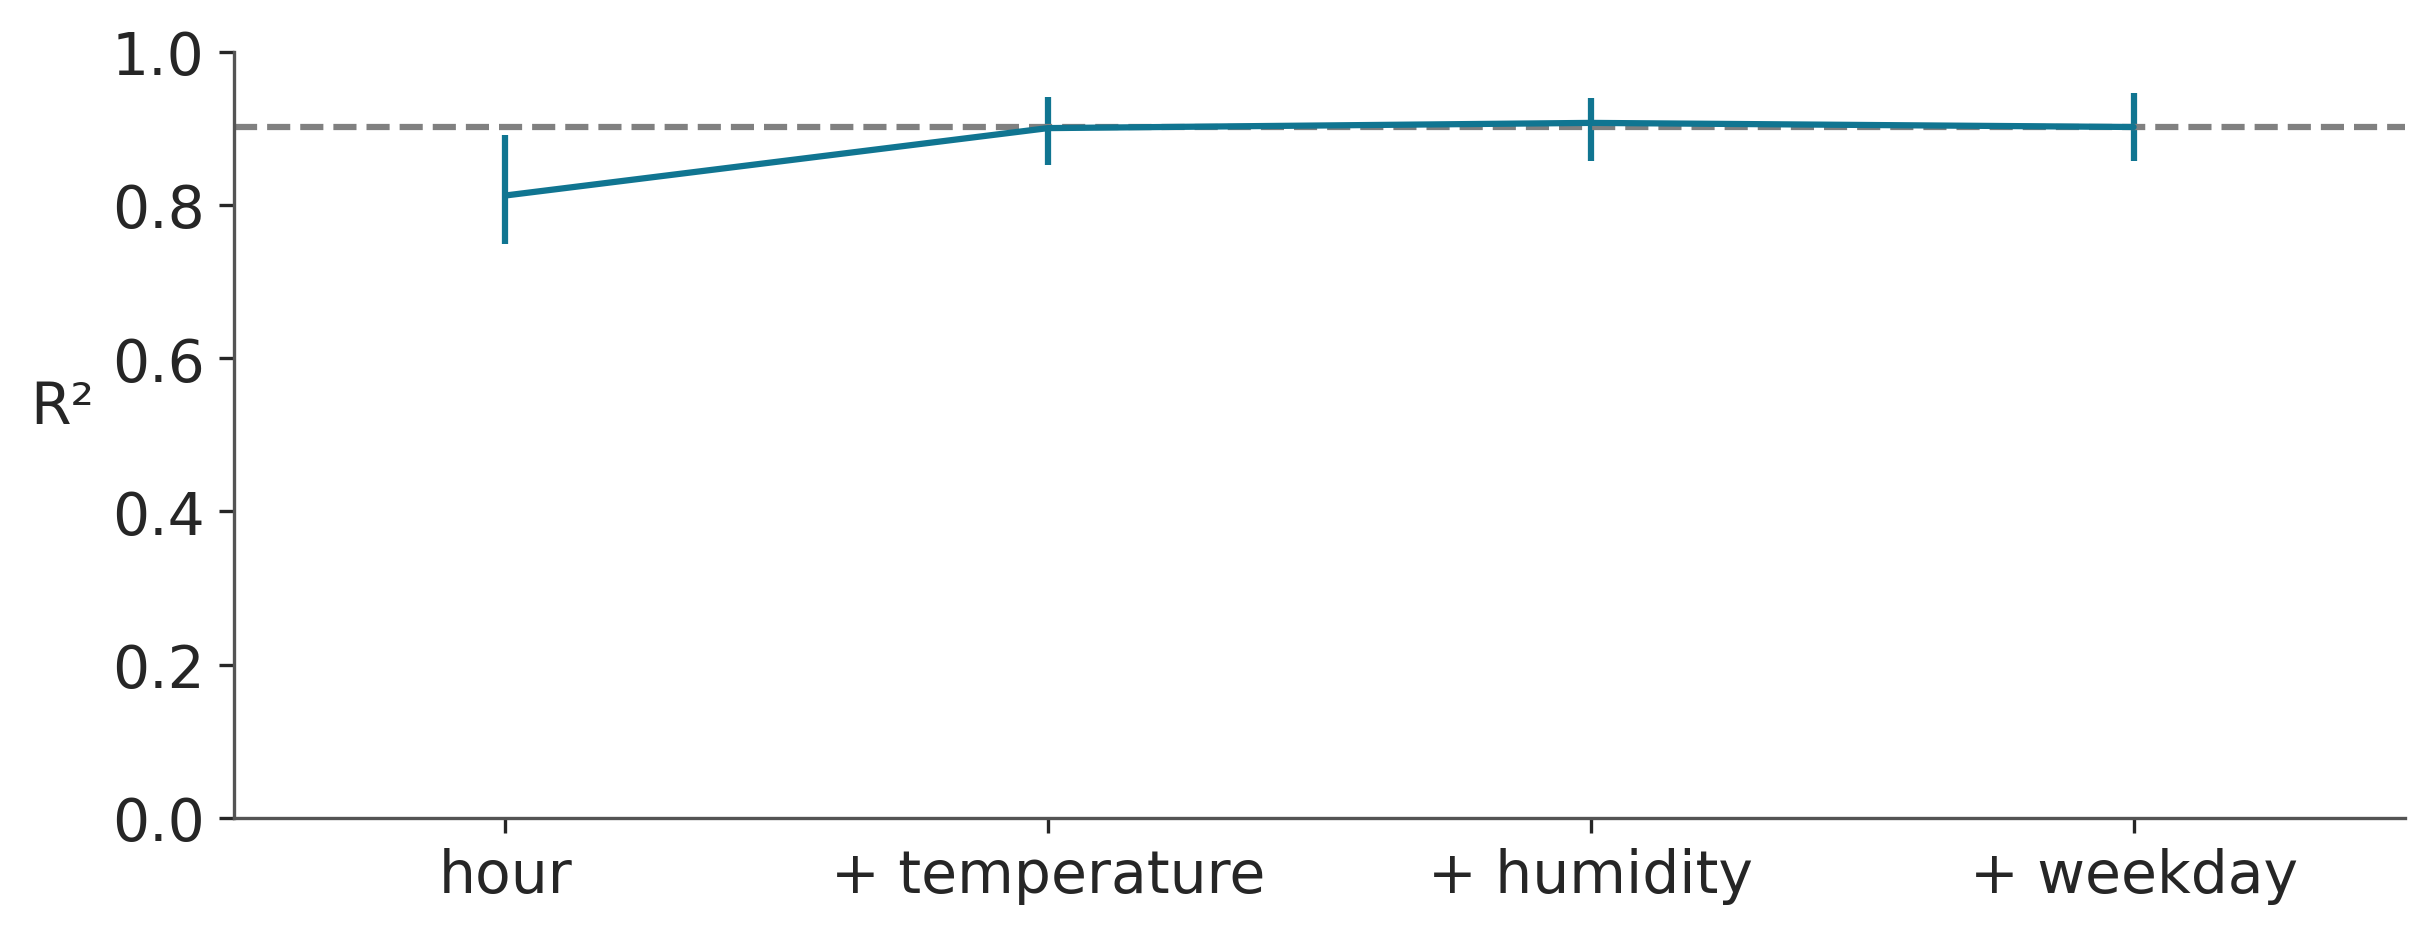

In [13]:
pmb.plot_variable_importance(idata_bikes, μ, X, method="backward");

## Modelos distribucionales con BART

## Respuestas Constantes y lineales